In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# benchmark class
from benchmark import ChurnBinaryBenchmark, ChurnProbaBenchmark

# models
from benchmark import BinaryMean, SimpleXbg, MajorityClass, SimpleKNN
from benchmark import SimpleXbgProba, RandomOrdered

# metrics
from benchmark import tp, fp, tn, fn
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, log_loss

## Data import

In [2]:
df_churn = pd.read_csv('data/Churn_Modelling.csv')
df_churn = df_churn.rename(columns={'Exited':'y'})
df_train, df_test = df_churn.iloc[:8000,:],  df_churn.iloc[8000:,:] # train/test split

## Building business specific benchmarks

In [3]:
# Defining the business case specific benchmark
class BusinessBenchmark():
    @staticmethod
    def run_benchmark(df_train, df_test):
        df = df_test.copy()
        df.loc[:,'y_hat'] = 0
        df.loc[(df['IsActiveMember'] == 0) & (df['Age'] >= 50), 'y_hat'] = 1
        return df['y_hat']

# Defining the business case specific reference metric
def financial_gain(y_true, y_pred):
    return np.sum(np.logical_and(y_pred == 1, y_true == 1)) * 1000 - np.sum(np.logical_and(y_pred == 1, y_true == 0)) * 250

binary_benchmark = ChurnBinaryBenchmark(
    metrics=[f1_score, precision_score, recall_score, tp, tn, fp, fn, financial_gain],
    benchmark_models=[BinaryMean, SimpleXbg, MajorityClass, SimpleKNN, BusinessBenchmark]
    )

# Making a prediction

In [4]:
df_train_model, df_test_model = df_train.copy(), df_test.copy()

# FE 
df_train_model['IsActive_by_CreditCard'] = df_train_model['HasCrCard'] * df_train_model['IsActiveMember']
df_train_model['Products_Per_Tenure'] =  df_train_model['Tenure'] / df_train_model['NumOfProducts']
df_test_model['IsActive_by_CreditCard'] = df_test_model['HasCrCard'] * df_test_model['IsActiveMember']
df_test_model['Products_Per_Tenure'] =  df_test_model['Tenure'] / df_test_model['NumOfProducts']

mapping_geo = df_train_model.groupby('Geography')['y'].mean()
mapping_gender = df_train_model.groupby('Gender')['y'].mean()

df_train_model['geo'] = df_train_model['Geography'].map(mapping_geo)
df_train_model['gender'] = df_train_model['Gender'].map(mapping_gender)
df_test_model['geo'] = df_test_model['Geography'].map(mapping_geo)
df_test_model['gender'] = df_test_model['Gender'].map(mapping_gender)


# XGB 
model = xgb.XGBClassifier(
    **{ 'n_estimators': 90,
        'max_depth': 3,
        'min_child_weight': 4,
        'learning_rate': 0.087,
        'subsample': 0.67,
        'colsample_bytree': 0.5}
 )

features = [
    'CreditScore', 
    'Age', 
    'Tenure', 
    'Balance', 
    'NumOfProducts', 
    'HasCrCard', 
    'IsActiveMember', 
    'EstimatedSalary', 
    'IsActive_by_CreditCard', 
    'Products_Per_Tenure', 
    'geo', 
    'gender'
    ]
target = ['y']

# Fit
model.fit(df_train_model[features], df_train_model[target])

# Predict
preds = model.predict(df_test_model[features])
preds_proba = model.predict_proba(df_test_model[features])

# Benchmark

In [5]:
res = binary_benchmark.compare_pred_with_benchmark(
    df_train=df_train,
    df_test=df_test,
    my_predictions=preds
)

pd.DataFrame(res)

c:\Users\mezzini\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Prediction,Benchmark - BinaryMean,Benchmark - SimpleXbg,Benchmark - MajorityClass,Benchmark - SimpleKNN,Benchmark - BusinessBenchmark
f1_score,0.537459,0.185232,0.477157,0.0,0.099617,0.294479
precision_score,0.736607,0.180929,0.701493,0.0,0.196970,0.727273
recall_score,0.423077,0.189744,0.361538,0.0,0.066667,0.184615
tp,165.000000,74.000000,141.000000,0.0,26.000000,72.000000
tn,1551.000000,1275.000000,1550.000000,1610.0,1504.000000,1583.000000
fp,59.000000,335.000000,60.000000,0.0,106.000000,27.000000
fn,225.000000,316.000000,249.000000,390.0,364.000000,318.000000
financial_gain,150250.000000,-9750.000000,126000.000000,0.0,-500.000000,65250.000000


In [6]:
res = binary_benchmark.compare_pred_with_benchmark(
    df_train=df_train,
    df_test=df_test,
    my_predictions=preds,
)

pd.DataFrame(res)

c:\Users\mezzini\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Prediction,Benchmark - BinaryMean,Benchmark - SimpleXbg,Benchmark - MajorityClass,Benchmark - SimpleKNN,Benchmark - BusinessBenchmark
f1_score,0.537459,0.185232,0.477157,0.0,0.099617,0.294479
precision_score,0.736607,0.180929,0.701493,0.0,0.196970,0.727273
recall_score,0.423077,0.189744,0.361538,0.0,0.066667,0.184615
tp,165.000000,74.000000,141.000000,0.0,26.000000,72.000000
tn,1551.000000,1275.000000,1550.000000,1610.0,1504.000000,1583.000000
fp,59.000000,335.000000,60.000000,0.0,106.000000,27.000000
fn,225.000000,316.000000,249.000000,390.0,364.000000,318.000000
financial_gain,150250.000000,-9750.000000,126000.000000,0.0,-500.000000,65250.000000


# Using a continuous target variable

,Prediction,SimpleXbgProba,RandomOrdered,BusinessBenchmark
roc_auc_score,0.859760,0.803924,0.464674,0.583923
log_loss,0.338809,0.448895,1.028982,6.217530


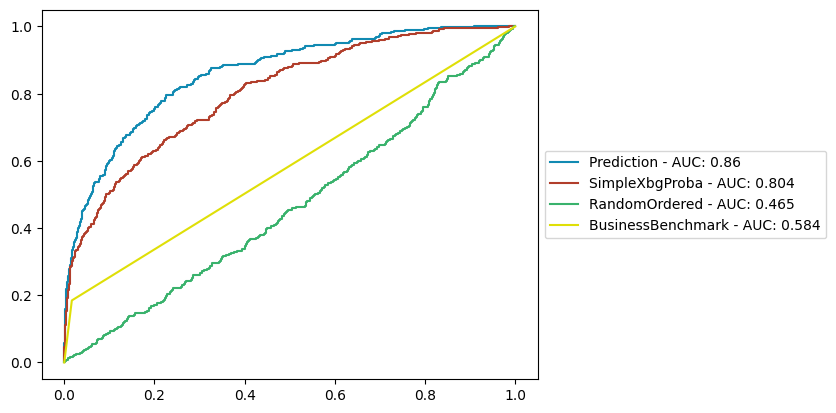

In [7]:
proba_benchmark = ChurnProbaBenchmark(
    metrics=[roc_auc_score, log_loss],
    benchmark_models= [SimpleXbgProba, RandomOrdered, BusinessBenchmark]
    )

res = proba_benchmark.compare_pred_with_benchmark(
    df_train=df_train,
    df_test=df_test,
    my_predictions=[x[1] for x in preds_proba],
    plots=True
)

pd.DataFrame(res)